In [1]:
from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')


# Mushroom Classification

The dataset can be found [here on Kaggle](https://www.kaggle.com/uciml/mushroom-classification)


In [51]:
cost_FP = 1
cost_FN = 20

import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import sklearn.preprocessing as skpr
import numpy as np
import csv

In [52]:
df = pd.read_csv('./datasets/mushrooms.csv')
# preprocessing
print("remove attribute 'Veil-type' as it is 100% of a single type, and thus isn't relevant.")
df = df.drop(['veil-type'],axis = 1) # remove column of data
# separate target from input X
attributes = list(df) # a list only takes the attribute names
X = df.iloc[:,1:]
Y = df.iloc[:,0]
# backup
X_original = X
Y_original = Y

remove attribute 'Veil-type' as it is 100% of a single type, and thus isn't relevant.


## Preprocessing

First, we can see we can easily remove the attribute 'Veil-type' as it is 100% of the type 'partial', there simply are no other types. This means it cannot help us classify mushrooms into Edible or Poisonous.

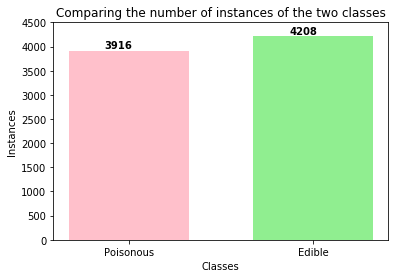

This means that the two classes are balanced.


In [53]:
x1 = len([x for x in Y if x=='p'])
x2 = len([x for x in Y if x=='e'])
# plot Classes
ind = np.arange(2)    # the x locations for the groups
width = .65           # the width of the bars
p1 = plt.bar(ind, [x1,x2], width, color=['pink','lightgreen'])
plt.ylabel('Instances')
plt.xlabel('Classes')
plt.title('Comparing the number of instances of the two classes')
plt.xticks(ind ,('Poisonous', 'Edible'))
plt.yticks(np.arange(0, max(x1,x2)+300, 500))
plt.text(ind[0]-width/5, x1 + .25+50, str(int(x1)), color='black', fontweight='bold')
plt.text(ind[1]-width/5, x2 + .25+50, str(int(x2)), color='black', fontweight='bold')
plt.show()
print("This means that the two classes are balanced.")


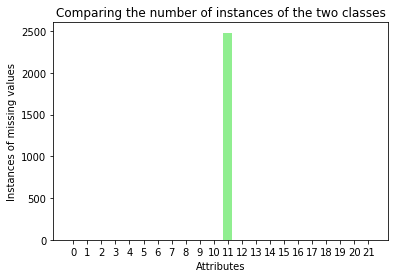

there are only missing values at attribute: stalk-root


In [54]:
# find missing data per attribute
#... column of classes where data is missing: plus the index of said entry
xcol = []
for column in df:
    xcol.append(len([x for x in df[column] if x=='?']))
    
# plot
ind = np.arange(len(xcol))    # the x locations for the groups
width = .65                   # the width of the bars
p1 = plt.bar(ind, xcol, width, color=['lightblue','lightgreen'])
plt.ylabel('Instances of missing values')
plt.xlabel('Attributes')
plt.title('Comparing the number of instances of the two classes')
plt.xticks(ind )
plt.yticks(np.arange(0, max(xcol)*1.2, 500))
plt.show()

id = np.nonzero(xcol)[0][0]
print(f"there are only missing values at attribute: {attributes[id]}")

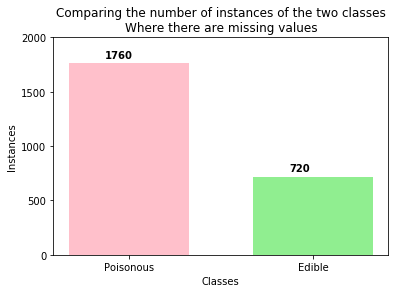

In [55]:
col = df[df.columns[id]]
index_missing = []
count1, count2 = 0,0
for i in df.index:
    if '?' in col[i]:
        index_missing.append(i)
        if Y[i] == 'p':
            count1+=1
        else:
            count2+=1

# plot Classes
ind = np.arange(2)    # the x locations for the groups
width = .65           # the width of the bars
p1 = plt.bar(ind, [count1,count2], width, color=['pink','lightgreen'])
plt.ylabel('Instances')
plt.xlabel('Classes')
plt.title('Comparing the number of instances of the two classes\nWhere there are missing values')
plt.xticks(ind ,('Poisonous', 'Edible'))
plt.yticks(np.arange(0, max(count1,count2)+300, 500))
plt.text(ind[0]-width/5, count1 + 50, str(count1), color='black', fontweight='bold')
plt.text(ind[1]-width/5, count2 + .25+50, str(count2), color='black', fontweight='bold')
plt.show()

So we now have 3 options to consider:
- Try to deduce the missing values
- Omit the attribute with the missing values altogether
- Consider the missing value as a new variable

First let's try to find the discrete missing values by using a KNN method.

## Finding the missing values

First remove every data point containing a missing value. We don't remove the attribute with the missing values. We set this attribute as the target to learn and use the classification 'Poisonous/edible' as input to the KNN. Then use KFold cross validation and also vary over the number of nearest neighbors of the KNN.

Remove the rows of data containing missing values , and normalize [0,1] the data

### should probably use OneHotEncoder instead of LabelEncoder (multiple features are then represented in a vector of length 1), but due to changes in Sklearn this needs to be sorted out

In [59]:
df_cut = df
#index = np.nonzero(x)[0]
#index = list(index)
#index_missing.reverse()
#data_arr = list(data_arr)
#Classes = list(Classes)

##remove missing data
df_cut = df_cut.drop(index_missing)
Y_cut = Y.drop(index_missing)

X_cut = df_cut.values 

from sklearn.preprocessing import LabelEncoder
Encoder = LabelEncoder()


In [63]:

for column in df_cut:
    df_cut[column] = Encoder.fit_transform(df_cut[column])

# normalize each Variable Column to range [0,1]
x = df_cut.values 
x = (x-x.min(axis=0))/(x.max(axis=0)-x.min(axis=0))
X_cut = pd.DataFrame(x,range(len(df_cut.index)),df_cut.columns)
Y_cut = pd.DataFrame(X_cut['class'])
X_cut = X_cut.drop(labels = 'class',axis = 1)


In [64]:

corr_matrix = df_cut.corr()
corr_matrix["class"].sort_values(ascending = False)
#print(corr_matrix)

class                       1.000000
habitat                     0.297412
gill-size                   0.215289
population                  0.203882
cap-color                   0.150741
cap-shape                   0.053155
veil-color                  0.047921
cap-surface                 0.046859
ring-number                 0.008615
gill-attachment            -0.071945
ring-type                  -0.215200
gill-spacing               -0.264160
stalk-root                 -0.291026
stalk-color-below-ring     -0.308613
stalk-color-above-ring     -0.317244
gill-color                 -0.318339
stalk-surface-below-ring   -0.363604
stalk-surface-above-ring   -0.375910
bruises                    -0.435562
odor                       -0.455566
spore-print-color          -0.507034
stalk-shape                -0.592446
Name: class, dtype: float64

In [65]:

print(X_cut.index)

RangeIndex(start=0, stop=5644, step=1)


In [66]:
#%% Vary the KNN

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold
kf = KFold(n_splits=10)

costl = []
acc = []
X = X_cut.values
Y = Y_cut.values.ravel()
for nbors in range(1,10):
    neigh = KNeighborsClassifier(n_neighbors=nbors)
    cost = 0
    it = 0
    it2 = 0
    
    for train_index, test_index in kf.split(X_cut):
        #print("TRAIN:", train_index, "TEST:", test_index)
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = Y[train_index], Y[test_index]
        
        
        neigh.fit(X_train, y_train)     
        t = neigh.predict(X_test )
        for i in range(len(t)):
            if t[i] == y_test[i]:
                it += 1
            if t[i] == 0 and y_test[i] == 1:
                cost += cost_FN
            if t[i] ==1 and y_test[i] == 0:
                cost += cost_FP
            it2 += 1
    costl.append(cost)
    acc.append(it/it2)


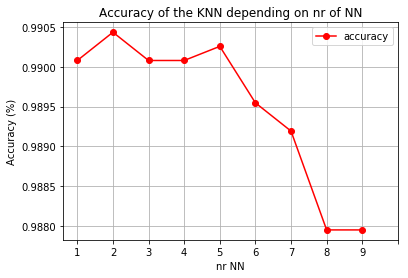

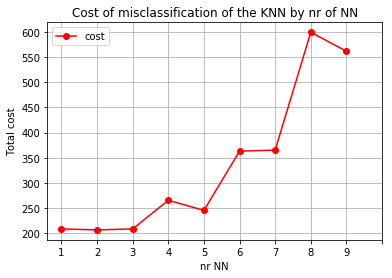

In [67]:
# plot

plt.plot(acc,'r-o',label = 'accuracy')
plt.xlabel('nr NN')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy of the KNN depending on nr of NN')
#for i in range(0,pc):
#    plt.text(i+0.25,np.cumsum(rho)[i]*100-5 , str(round(np.cumsum(rho)[i]*100,1)), color='black', fontsize=9, rotation=90)
plt.grid(True)
plt.xticks(range(0,len(acc)+1),range(1,len(acc)+1))
plt.legend()
plt.show()


plt.plot(costl,'r-o',label = 'cost')
plt.xlabel('nr NN')
plt.ylabel('Total cost')
plt.title('Cost of misclassification of the KNN by nr of NN')
#for i in range(0,pc):
#    plt.text(i+0.25,np.cumsum(rho)[i]*100-5 , str(round(np.cumsum(rho)[i]*100,1)), color='black', fontsize=9, rotation=90)
plt.grid(True)
plt.xticks(range(0,len(acc)+1),range(1,len(acc)+1))
plt.legend()
plt.show()



This was used for predicting the classficiation , which gave us k = 3. 

Now let's compare this with a couple of other methods.

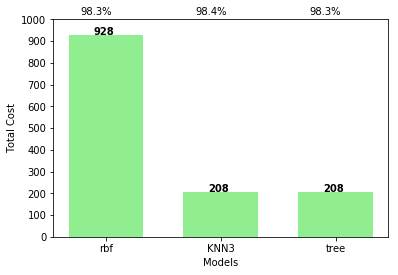

In [70]:
from sklearn import svm

C=1.0

from scipy.io import loadmat
from sklearn import model_selection, tree
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from mlxtend.plotting import plot_confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier

modelname = ["rbf",'KNN3','tree']

def runtests(mat4,Classes_org):                  
    positive = 1
    negative = 0 
    std = []
    ac = []
    cost = []
    C = 1.0
    models = (svm.SVC(kernel='rbf', gamma=0.7, C=C),
              KNeighborsClassifier(n_neighbors=3),
              tree.DecisionTreeClassifier())
    
    X = mat4
    Y = Classes_org
    for L in range(len(models)):
        
        C = 1.0
        clf = models[L]
        #clf.fit(X, Y)  
        
        
        
        TP2 = np.zeros(10)
        TN2 = np.zeros(10)
        FP2 = np.zeros(10)
        FN2 = np.zeros(10)
        
        
        
        
        kf = KFold(n_splits=10)
        kf.get_n_splits(X)
        
        #print(kf)  
        #KFold(n_splits=10, random_state=None, shuffle=False)
        
        i = 0
        if models[L]!= 'tree':
            for train_index, test_index in kf.split(X):
                #print("TRAIN:", train_index, "TEST:", test_index)
                X_train, X_test = X[train_index,:], X[test_index,:]
                y_train, y_test = Y[train_index], Y[test_index]

                clf.fit(X_train, y_train)
                y_predict = clf.predict(X_test)
                #print("len = {}".format(len(y_test)))
                TP2[i] = len(list(set(np.where(y_test==positive)[0]).intersection(set(np.where(y_predict ==positive)[0]))))#*100/len(y_test)
                TN2[i] = len(list(set(np.where(y_test==negative)[0]).intersection(set(np.where(y_predict ==negative)[0]))))#*100/len(y_test)
                FP2[i] = len(list(set(np.where(y_test==negative)[0]).intersection(set(np.where(y_predict ==positive)[0]))))#*100/len(y_test)
                FN2[i] = len(list(set(np.where(y_test==positive)[0]).intersection(set(np.where(y_predict ==negative)[0]))))#*100/len(y_test)

                i=i+1
            TP2 = sum(TP2)
            TN2 = sum(TN2)
            FP2 = sum(FP2)
            FN2 = sum(FN2)    
            accuracy = (TP2+TN2)/(TP2+TN2+FN2+FP2)*100
            totalcost = FP2*cost_FP+FN2*cost_FN
        else:
            pass
            for t in range(10):
                listing = []
                costlist = []
                modellist = []
                for train_index, test_index in kf.split(X):
                    #print("TRAIN:", train_index, "TEST:", test_index)
                    X_train, X_test = X[train_index,:], X[test_index,:]
                    y_train, y_test = Y[train_index], Y[test_index]

                    clf.fit(X_train, y_train)
                    y_predict = clf.predict(X_test)
                    #print("len = {}".format(len(y_test)))
                    TP2[i] = len(list(set(np.where(y_test==positive)[0]).intersection(set(np.where(y_predict ==positive)[0]))))#*100/len(y_test)
                    TN2[i] = len(list(set(np.where(y_test==negative)[0]).intersection(set(np.where(y_predict ==negative)[0]))))#*100/len(y_test)
                    FP2[i] = len(list(set(np.where(y_test==negative)[0]).intersection(set(np.where(y_predict ==positive)[0]))))#*100/len(y_test)
                    FN2[i] = len(list(set(np.where(y_test==positive)[0]).intersection(set(np.where(y_predict ==negative)[0]))))#*100/len(y_test)

                    i=i+1
                
                TP2 = sum(TP2)
                TN2 = sum(TN2)
                FP2 = sum(FP2)
                FN2 = sum(FN2)    
                accuracy = (TP2+TN2)/(TP2+TN2+FN2+FP2)*100
                totalcost = FP2*cost_FP+FN2*cost_FN
                #if costlist
                #costlist.append()
        scores = cross_val_score(clf, X[:,:], Y, cv=10)
        #print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
        #ac.append(scores.mean()*100)
        std.append(scores.std())
        
        
        
        ac.append(scores.mean()*100)

        
        cost.append(totalcost)
        
    return cost, ac, std

cost,ac,std = runtests(X_cut.values,Y_cut.values.ravel())



ind = np.arange(len(modelname))    # the x locations for the groups
width = .65       # the width of the bars: can also be len(x) sequence

p1 = plt.bar(ind, cost, width, color='lightgreen')


plt.ylabel('Total Cost')
plt.xlabel('Models')
#plt.title('The cost per model and accuracy')
plt.xticks(ind ,modelname)

plt.yticks(np.arange(0, max(cost)*1.1, 100))

for i in ind:
    plt.text(ind[i]-width/6, cost[i] + .25, str(int(cost[i])), color='black', fontweight='bold')
    plt.text(ind[i]-width/2+0.1, max(cost)*1.1, str(round(ac[i],1))+"%", color='black')

plt.show()

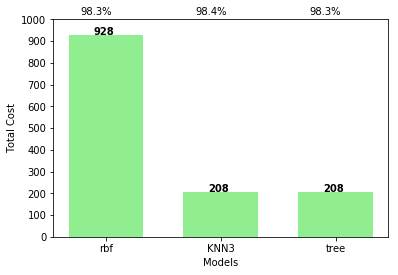

In [71]:
ind = np.arange(len(modelname))    # the x locations for the groups
width = .65       # the width of the bars: can also be len(x) sequence

p1 = plt.bar(ind, cost, width, color='lightgreen')


plt.ylabel('Total Cost')
plt.xlabel('Models')
#plt.title('The cost per model and accuracy')
plt.xticks(ind ,modelname)

plt.yticks(np.arange(0, max(cost)*1.1, 100))

for i in ind:
    plt.text(ind[i]-width/6, cost[i] + .25, str(int(cost[i])), color='black', fontweight='bold')
    plt.text(ind[i]-width/2+0.1, max(cost)*1.1, str(round(ac[i],1))+"%", color='black')

plt.show()

Because of the performance of the Decision Tree I decide to use this for the missing values


In [72]:
#%% predict missing values
acc = []
cost = 0
it = 0
it2 = 0
clf = tree.DecisionTreeClassifier()
# remove missing attribute-column from the data
# data_arr does not contain the datapoints containing missing values. First train on the complete data to fill in the incomplete data
X = np.concatenate((data_arr[:,0:id],data_arr[:,id+1:] ),axis = 1)
# and set it as the target
y = data_arr[:,id]


Encoder = LabelEncoder()
y_encoded = Encoder.fit_transform(y)
clf.fit(X, y_encoded)  

# create new matrices from the original full dataset containing the missing values
data2 = data[:,0:id]
data3 = data[:,id+1:]

# encode: symbol -> numerical value
Encoder = LabelEncoder()
for i in range(len(data2[0,:])):
    data2[:,i] = Encoder.fit_transform(data2[:,i])
for i in range(len(data3[0,:])):
    data3[:,i] = Encoder.fit_transform(data3[:,i])

# normalize the data
data2 = data2.astype(float)
data3 = data3.astype(float)
for i in range(len(data2[0,:])):
    x = data2[:,i].astype(float)
    C = max(x)
    data2[:,i] = [float(k/C) for k in x]

for i in range(len(data3[0,:])):
    x = data3[:,i].astype(float)
    C = max(x)
    data3[:,i] = [float(k/C) for k in x]

# 1 2|3|4 5 
# 1 2|3|4 5
#----------
# 1 2|?|4 5
# 1 2|?|4 5

# will then be combined into matrices

# 1245
# 1245

# with targets
# 3 or ? to predict

mat = []
mat2 = []
mat3 = []
tgt = []
data_line = data[:,id]
for i in range(len(data[:,0])):
    if i in index: #contains a missing value
        mat2.append(np.concatenate((data2[i,:].ravel(),data3[i,:].ravel()),axis=0))
    else:
        mat.append(np.concatenate((data2[i,:][:,np.newaxis].ravel(),np.array(data_line[i]).ravel(),data3[i,:][:,np.newaxis].ravel()), axis=0, out=None))
        mat3.append(np.concatenate((data2[i,:][:,np.newaxis].ravel(),data3[i,:][:,np.newaxis].ravel()), axis=0, out=None))
        tgt.append(data_line[i]) 
        #%% apply it for missing data

        
# normalize the targets
tgt = Encoder.fit_transform(tgt)
C = max(tgt)
tgt = [float(k/C) for k in tgt]
        
mat = np.array(mat)
mat2 = np.array(mat2)
mat3 = np.array(mat3)

# targets should be 'string' and not continuous numbers, we can solve this by simply by:
for i in range(len(tgt)):
    tgt[i] = str(tgt[i])
#%% predict missing values and put them in the data
clf = tree.DecisionTreeClassifier()
clf.fit(mat3, tgt)  
t = clf.predict(mat2)
mat4 = []
k = 0
h = 0
# complete the dataset
for i in range(len(data[:,0])):
    
    if i in index: #contains a missing value
        mat4.append(np.concatenate((data2[i,:].ravel(), np.array(float(t[k])).ravel()  , data3[i,:].ravel()),axis=0))
        k += 1
    else:
        mat4.append(np.concatenate((data2[i,:][:,np.newaxis].ravel(),np.array(tgt[h]).ravel(),data3[i,:][:,np.newaxis].ravel()), axis=0, out=None))
        h += 1
#%%
mat4 = np.array(mat4)


NameError: name 'data_arr' is not defined

In [75]:
mat4 = mat4.astype(float)

In [76]:
#%% compare svms

from sklearn import svm

C=1.0

from scipy.io import loadmat
from sklearn import model_selection, tree
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from mlxtend.plotting import plot_confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import KFold

linestyle = ['r-', 'g--', 'b:', 'y-.','c-','m.']
    
modelname = ["linear","linearSVC","rbf","poly2","poly3","poly4",'KNN3','tree']     
def runtests(mat4,Classes_org):                  
    std = []
    ac = []
    cost = []
    C = 1.0
    models = (svm.SVC(kernel='linear', C=C),
              svm.LinearSVC(C=C),
              svm.SVC(kernel='rbf', gamma=0.7, C=C),
              svm.SVC(kernel='poly', degree=2, C=C),
              svm.SVC(kernel='poly', degree=3, C=C),
              svm.SVC(kernel='poly', degree=4, C=C),
              KNeighborsClassifier(n_neighbors=3),
              tree.DecisionTreeClassifier())
    
    X = mat4
    Y = Classes_org
    for L in range(len(models)):
        
        C = 1.0
        clf = models[L]
        clf.fit(X, Y)  
        
        
        
        TP2 = np.zeros(10)
        TN2 = np.zeros(10)
        FP2 = np.zeros(10)
        FN2 = np.zeros(10)
        
        
        
        
        kf = KFold(n_splits=10)
        kf.get_n_splits(X)
        
        #print(kf)  
        #KFold(n_splits=10, random_state=None, shuffle=False)
        
        i = 0
        for train_index, test_index in kf.split(X):
            #print("TRAIN:", train_index, "TEST:", test_index)
            X_train, X_test = X[train_index,:], X[test_index,:]
            y_train, y_test = Y[train_index], Y[test_index]
            
            clf.fit(X_train, y_train)
            y_predict = clf.predict(X_test)
            #print("len = {}".format(len(y_test)))
            TP2[i] = len(list(set(np.where(y_test=='p')[0]).intersection(set(np.where(y_predict =='p')[0]))))#*100/len(y_test)
            TN2[i] = len(list(set(np.where(y_test=='e')[0]).intersection(set(np.where(y_predict =='e')[0]))))#*100/len(y_test)
            FP2[i] = len(list(set(np.where(y_test=='e')[0]).intersection(set(np.where(y_predict =='p')[0]))))#*100/len(y_test)
            FN2[i] = len(list(set(np.where(y_test=='p')[0]).intersection(set(np.where(y_predict =='e')[0]))))#*100/len(y_test)
            
            i=i+1
            
            
        
        scores = cross_val_score(clf, X[:,:], Y, cv=10)
        #print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
        #ac.append(scores.mean()*100)
        #std.append(scores.std())
        
        TP2 = sum(TP2)
        TN2 = sum(TN2)
        FP2 = sum(FP2)
        FN2 = sum(FN2)
        
        ac.append((TP2+TN2)/(TP2+TN2+FN2+FP2)*100)
        
        #plt.subplots_adjust(wspace=0.4, hspace=0.4)
        
        
        
        cost.append(FP2*cost_FP+FN2*cost_FN)
        
        if L==2:
            rbf_matrix = np.array([[TP2,FN2],[FP2,TN2]])
        if L==0:
            lin_matrix = np.array([[TP2,FN2],[FP2,TN2]])
    return cost, ac

cost,ac = runtests(mat4,Classes_org)


Accuracy: 0.88 (+/- 0.25)
Accuracy: 0.88 (+/- 0.27)
Accuracy: 0.96 (+/- 0.19)
Accuracy: 0.90 (+/- 0.26)
Accuracy: 0.88 (+/- 0.25)
Accuracy: 0.88 (+/- 0.26)
Accuracy: 0.96 (+/- 0.19)
Accuracy: 0.95 (+/- 0.21)


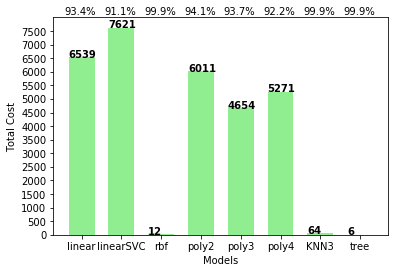

Accuracy: 0.90 (+/- 0.22)
Accuracy: 0.88 (+/- 0.28)
Accuracy: 0.96 (+/- 0.19)
Accuracy: 0.90 (+/- 0.24)
Accuracy: 0.88 (+/- 0.27)
Accuracy: 0.88 (+/- 0.27)
Accuracy: 0.96 (+/- 0.18)
Accuracy: 0.97 (+/- 0.19)


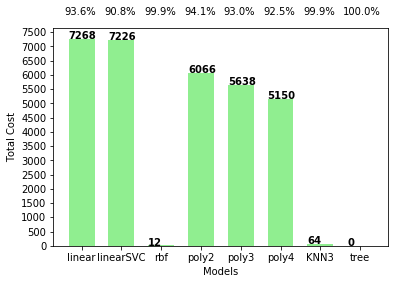

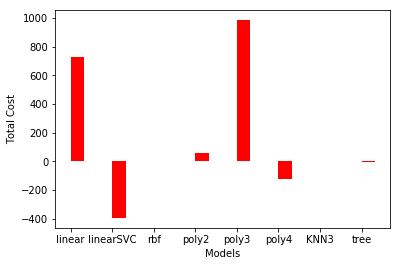

Accuracy: 0.88 (+/- 0.26)
Accuracy: 0.89 (+/- 0.25)
Accuracy: 0.96 (+/- 0.19)
Accuracy: 0.89 (+/- 0.25)
Accuracy: 0.88 (+/- 0.25)
Accuracy: 0.88 (+/- 0.26)
Accuracy: 0.96 (+/- 0.19)
Accuracy: 0.97 (+/- 0.19)


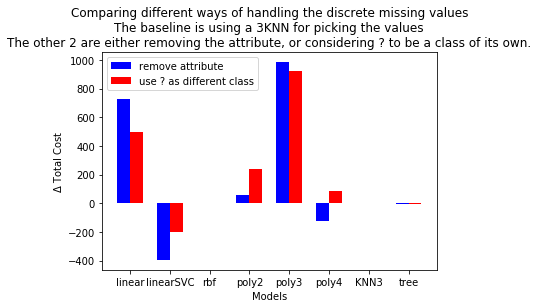

This means that there is no noticable difference between the three methods when you use the 3 best classifiers


In [77]:
#%%
# add the cost of the Decision Tree model
#cost.append(tree_cost)
#ac.append(tree_acc)


ind = np.arange(len(modelname))    # the x locations for the groups
width = .65       # the width of the bars: can also be len(x) sequence

p1 = plt.bar(ind, cost, width, color='lightgreen')


plt.ylabel('Total Cost')
plt.xlabel('Models')
#plt.title('The cost per model and accuracy')
plt.xticks(ind ,modelname)

plt.yticks(np.arange(0, 8000, 500))

for i in ind:
    plt.text(ind[i]-width/2, cost[i] + .25, str(int(cost[i])), color='black', fontweight='bold')
    plt.text(ind[i]-width/2-0.1, 8100, str(round(ac[i],1))+"%", color='black')

plt.show()

#%%
mat5 = np.delete(mat4,id,1)

cost2,ac2 = runtests(mat5,Classes_org)

#%%
# add the cost of the Decision Tree model
#cost.append(tree_cost)
#ac.append(tree_acc)




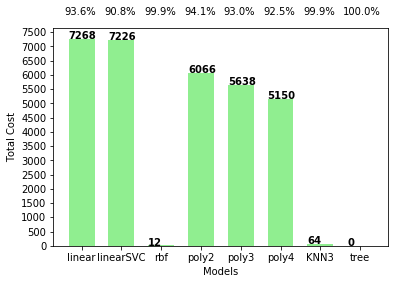

'\nfor i in ind:\n    plt.text(ind[i]-width/2, cost2[i] + .25, str(int(cost2[i])), color=\'black\', fontweight=\'bold\')\n    plt.text(ind[i]-width/2-0.1, 8100, str(round(ac2[i],1))+"%", color=\'black\')\n'

In [81]:
ind = np.arange(len(modelname))    # the x locations for the groups
width = .65       # the width of the bars: can also be len(x) sequence

p1 = plt.bar(ind, cost2, width, color='lightgreen')


plt.ylabel('Total Cost')
plt.xlabel('Models')
#plt.title('The cost per model and accuracy')
plt.xticks(ind ,modelname)

plt.yticks(np.arange(0, 8000, 500))

for i in ind:
    plt.text(ind[i]-width/2, cost2[i] + .25, str(int(cost2[i])), color='black', fontweight='bold')
    plt.text(ind[i]-width/2-0.1, 8100, str(round(ac2[i],1))+"%", color='black')

plt.show()

#%%

ac3 = []
for i in range(len(ac)):
    
    ac3.append((ac2[i]-ac[i])/ac[i]*100)
#%% apply this only to the 3 best methods
ind = np.arange(len(modelname))    # the x locations for the groups
width = .65       # the width of the bars: can also be len(x) sequence

#p1 = plt.bar(ind-width/4, cost2, width/2, color='green')
cost3 = []
for i in range(len(cost)):
    #cost3.append((cost2[i]-cost[i])/cost[i]*100)
    cost3.append((cost2[i]-cost[i]))
"""
p2 = plt.bar(ind+width/4, cost3, width/2, color='red')

plt.ylabel('Total Cost')
plt.xlabel('Models')
#plt.title('The cost per model and accuracy')
plt.xticks(ind ,modelname)

#plt.yticks(np.arange(0, max(cost3), 1))
"""
"""
for i in ind:
    plt.text(ind[i]-width/2, cost2[i] + .25, str(int(cost2[i])), color='black', fontweight='bold')
    plt.text(ind[i]-width/2-0.1, 8100, str(round(ac2[i],1))+"%", color='black')
"""
#plt.show()



In [ ]:

#%%
x = data_org[:,id]
z = list(map( replacemissing ,x))
    


Encoder = LabelEncoder()
for i in range(len(data_arr[0,:])):
    data_org[:,i] = Encoder.fit_transform(data_org[:,i])

#% Normalize the data
from sklearn.preprocessing import normalize
data_org = data_org.astype(float)
for i in range(len(data_org[0,:])):
    x = data_org[:,i].astype(float)
    C = max(x)
    data_org[:,i] = [float(k/C) for k in x]
    
#%%
cost4,ac4 = runtests(data_org,Classes_org)




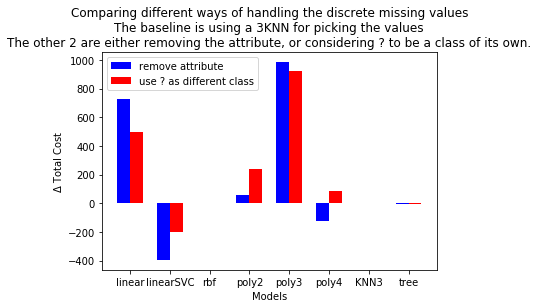

This means that there is no noticable difference between the three methods when you use the 3 best classifiers


In [82]:
#%% apply this only to the 3 best methods
ind = np.arange(len(modelname))    # the x locations for the groups
width = .65       # the width of the bars: can also be len(x) sequence

#p1 = plt.bar(ind-width/4, cost2, width/2, color='green')
cost5 = []
for i in range(len(cost)):
    #cost5.append((cost4[i]-cost[i])/cost[i]*100)
    cost5.append((cost4[i]-cost[i]))
p1 = plt.bar(ind-width/4, cost3, width/2, color='blue',label = 'remove attribute')
p2 = plt.bar(ind+width/4, cost5, width/2, color='red',label = 'use ? as different class')

plt.ylabel('$\Delta$ Total Cost')
plt.xlabel('Models')
#plt.title('The cost per model and accuracy')
plt.xticks(ind ,modelname)
plt.legend()
plt.title("Comparing different ways of handling the discrete missing values\nThe baseline is using a 3KNN for picking the values\nThe other 2 are either removing the attribute, or considering ? to be a class of its own.")
#plt.yticks(np.arange(0, max(cost3), 100))
"""
for i in ind:
    plt.text(ind[i]-width/2, cost2[i] + .25, str(int(cost2[i])), color='black', fontweight='bold')
    plt.text(ind[i]-width/2-0.1, 8100, str(round(ac2[i],1))+"%", color='black')
"""
plt.show()
print("This means that there is no noticable difference between the three methods when you use the 3 best classifiers")


This means that this specific attribute does not contribute, and thus can be removed from the dataset.

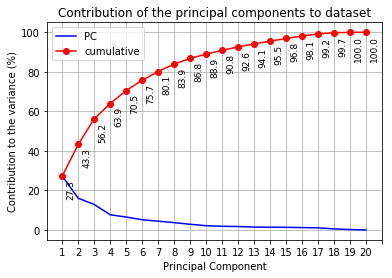

In [85]:
len(mat5[:,0])
# PCA
X = mat5


mu = X.mean(0)                   # determine mean per column
mu = np.tile(mu,(len(X[:,0]),1)) # repeat vector into matrix
#mean center the data
Y1 = X - mu 
#
U, s, V = np.linalg.svd(Y1, full_matrices=True) #s is the vector which contains the values of a diagonal-matrix
# to matrix for matrix multiplication
V = np.matrix(V)
Y1 = np.matrix(Y1)

#projection of data onto all 9 PC's
pc = len(mat5[0,:])
Z = np.zeros([len(mat5),pc])
for i in range(pc-1):
    Z[:,i] = (Y1*V[:,i]).ravel()


rho = s**2/sum(s**2)

plt.plot(rho*100,'b',label = 'PC')
plt.plot(np.cumsum(rho)*100,'r-o',label = 'cumulative')


plt.xlabel('Principal Component')
plt.ylabel('Contribution to the variance (%)')
plt.title('Contribution of the principal components to dataset')
for i in range(0,pc):
    plt.text(i+0.25,np.cumsum(rho)[i]*100-5 , str(round(np.cumsum(rho)[i]*100,1)), color='black', fontsize=9, rotation=90)
plt.grid(True)
plt.xticks(range(0,pc+1),range(1,pc+1))
plt.legend()
plt.show()


In [131]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.patches as mpatches
Y = Classes_org
Clist = []
for i in range(len(Y)):
    if Y[i]=='p':
        Clist.append('red')
    else:
        Clist.append('blue')

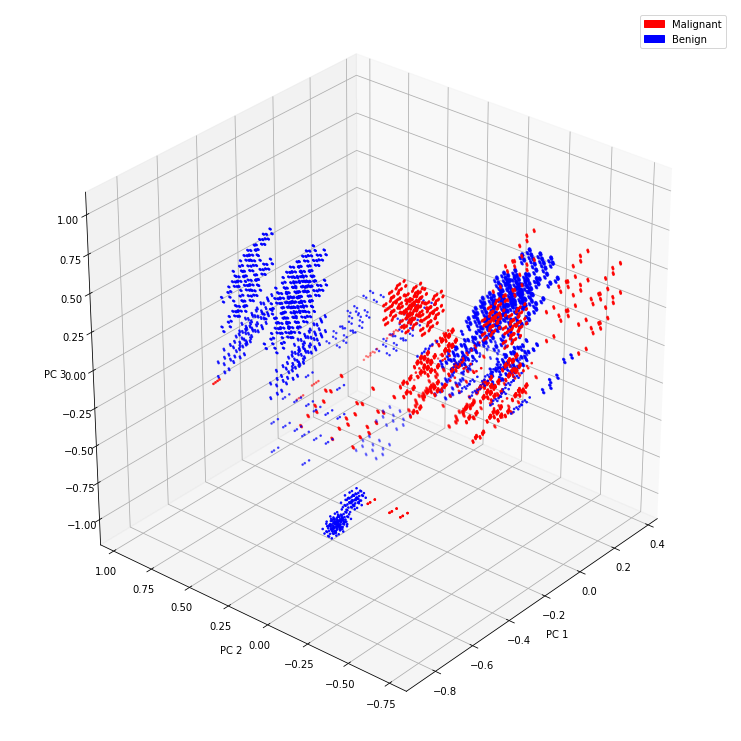

In [140]:


fig = plt.figure(figsize=(10,10))
ax = Axes3D(fig)

ax.scatter(Z[:,0],Z[:,1],Z[:,2], s=10,color = Clist, marker='.')
angle = 220#240
ax.view_init(30, angle)
red_patch = mpatches.Patch(color='red', label='Malignant')
blue_patch = mpatches.Patch(color='blue', label='Benign')
plt.legend(handles=[red_patch,blue_patch])
xLabel = ax.set_xlabel('PC 1', linespacing=3.2)
yLabel = ax.set_ylabel('PC 2', linespacing=3.1)
zLabel = ax.set_zlabel('PC 3', linespacing=3.4)
plt.show()
